In [1]:
dataset_base_path = r'/Users/kripik123/Desktop/dataset/processed'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
##from sklearn.dummy import DummyClassifier
##from sklearn.linear_model import LogisticRegression
##from sklearn.ensemble import RandomForestClassifier
##from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
##from sklearn.naive_bayes import GaussianNB
##from sklearn.neighbors import KNeighborsClassifier
##from sklearn.tree import DecisionTreeClassifier
##from sklearn.svm import SVC
##from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
from catboost import CatBoostClassifier
from catboost import Pool
##from scipy.stats import spearmanr
##from scipy.cluster import hierarchy
##from collections import defaultdict
##from scipy.stats import describe
##from collections import Counter
##from IPython.display import display
from time import time #time stamp for all processing time
##from sklearn.feature_selection import RFE


%matplotlib inline

In [3]:
types = {
    'dst_port': 'uint32',
    'protocol': 'uint8',
    'timestamp': 'object',
    'flow_duration': 'int64',
    'tot_fwd_pkts': 'uint32',
    'tot_bwd_pkts': 'uint32',
    'totlen_fwd_pkts': 'uint32',
    'totlen_bwd_pkts': 'uint32',
    'fwd_pkt_len_max': 'uint16',
    'fwd_pkt_len_min': 'uint16',
    'fwd_pkt_len_mean': 'float32',
    'fwd_pkt_len_std': 'float32',
    'bwd_pkt_len_max': 'uint16',
    'bwd_pkt_len_min': 'uint16',
    'bwd_pkt_len_mean': 'float32',
    'bwd_pkt_len_std': 'float32',
    'flow_byts_s': 'float64',
    'flow_pkts_s': 'float64',
    'flow_iat_mean': 'float32',
    'flow_iat_std': 'float32',
    'flow_iat_max': 'int64',
    'flow_iat_min': 'int64',
    'fwd_iat_tot': 'int64',
    'fwd_iat_mean': 'float32',
    'fwd_iat_std': 'float32',
    'fwd_iat_max': 'int64',
    'fwd_iat_min': 'int64',
    'bwd_iat_tot': 'uint32',
    'bwd_iat_mean': 'float32',
    'bwd_iat_std': 'float32',
    'bwd_iat_max': 'uint32',
    'bwd_iat_min': 'uint32',
    'fwd_psh_flags': 'uint8',
    'bwd_psh_flags': 'uint8',
    'fwd_urg_flags': 'uint8',
    'bwd_urg_flags': 'uint8',
    'fwd_header_len': 'uint32',
    'bwd_header_len': 'uint32',
    'fwd_pkts_s': 'float32',
    'bwd_pkts_s': 'float32',
    'pkt_len_min': 'uint16',
    'pkt_len_max': 'uint16',
    'pkt_len_mean': 'float32',
    'pkt_len_std': 'float32',
    'pkt_len_var': 'float32',
    'fin_flag_cnt': 'uint8',
    'syn_flag_cnt': 'uint8',
    'rst_flag_cnt': 'uint8',
    'psh_flag_cnt': 'uint8',
    'ack_flag_cnt': 'uint8',
    'urg_flag_cnt': 'uint8',
    'cwe_flag_count': 'uint8',
    'ece_flag_cnt': 'uint8',
    'down_up_ratio': 'uint16',
    'pkt_size_avg': 'float32',
    'fwd_seg_size_avg': 'float32',
    'bwd_seg_size_avg': 'float32',
    'fwd_byts_b_avg': 'uint8',
    'fwd_pkts_b_avg': 'uint8',
    'fwd_blk_rate_avg': 'uint8',
    'bwd_byts_b_avg': 'uint8',
    'bwd_pkts_b_avg': 'uint8',
    'bwd_blk_rate_avg': 'uint8',
    'subflow_fwd_pkts': 'uint32',
    'subflow_fwd_byts': 'uint32',
    'subflow_bwd_pkts': 'uint32',
    'subflow_bwd_byts': 'uint32',
    'init_fwd_win_byts': 'int32',
    'init_bwd_win_byts': 'int32',
    'fwd_act_data_pkts': 'uint32',
    'fwd_seg_size_min': 'uint8',
    'active_mean': 'float32',
    'active_std': 'float32',
    'active_max': 'uint32',
    'active_min': 'uint32',
    'idle_mean': 'float32',
    'idle_std': 'float32',
    'idle_max': 'uint64',
    'idle_min': 'uint64',
    'label': 'category'
}

def replace_infinity_with_mean(df):
    inf_columns = [c for c in df.columns if df[df[c] == np.inf][c].count() > 0]
    for col in inf_columns:
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df


def replace_negative_values_with_mean(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.values
    
    columns = [c for c in numeric_cols if df[df[c] < 0][c].count() > 0]
    for col in columns:
        mask = df[col] < 0
        df.loc[mask, col] = np.nan
        mean = df[col].mean()
        df[col].fillna(mean, inplace=True)
    return df

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def load_dataset(files, dtypes, cols=None):
    df = pd.concat((pd.read_csv(f, dtype=dtypes, usecols=cols) for f in files))
    
    df = replace_infinity_with_mean(df)
    df = replace_negative_values_with_mean(df)
        
    df['label_cat'] = df.label.astype('category').cat.codes
    df['label_is_attack'] = (df.label != 'Benign').astype('int')
    return df

2. Prepocesing data

In [4]:
#join all csv
#split data jadi-2 X dan Y
csv_files = glob.glob(os.path.join(dataset_base_path, 'infiltration_01-03-2018.csv'))

df = load_dataset(csv_files, types)
X = df.drop(columns=['label', 'label_cat', 'label_is_attack'])
y = df[['label_is_attack', 'label_cat', 'label']]

In [5]:
#fitur yang nilainya 0 dicari 

stats = X.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    bwd_blk_rate_avg
5      bwd_byts_b_avg
6      bwd_pkts_b_avg
0       bwd_psh_flags
1       bwd_urg_flags
4    fwd_blk_rate_avg
2      fwd_byts_b_avg
3      fwd_pkts_b_avg
dtype: object

In [6]:
#fitur yang nilainya 0 dihapus
X = X.drop(columns=features_no_variance)

In [7]:
#fitur timestamp dan dst_port bertipe obyek, maka dihapus saja
X = X.drop(columns=['timestamp', 'dst_port'])

Optimal number of features : 5
Num Features: 5
Selected Features: [ True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False  True
 False False  True False False False False False False False False]
Feature Ranking: [ 1  1 46  6 29 56 42 50  4 60  9 27 11 62 35 37 28  5 10 22 14 18  8 12
 26 16 17 24 34 40 38 33 65 43 30 48 13  7 64  1 31 15 41 67 66 44  2 25
 58 61 20 19 23 21 32 39 36 57 49  1  3 51  1 54 63 53 52 47 55 59 45]


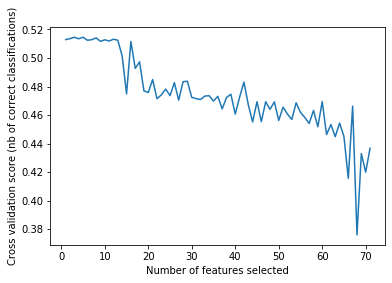

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
##from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

##model = LogisticRegression()
model = ExtraTreesClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y.label_is_attack)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

print("Num Features: %d" % (rfecv.n_features_,))
print("Selected Features: %s" % (rfecv.support_,))
print("Feature Ranking: %s" % (rfecv.ranking_,))
plt.show()

In [10]:
#Fitur yang memiliki korelasi tinggi antar sesamanya dihapus

X = X[selected_features]
print(f"Remaining amount of features: {len(X.columns)}")

Remaining amount of features: 32


In [12]:
def print_report(ds_type, cls, X_vals, y_true, y_predict, plot_pr=False, plot_roc=False):
    print(f"Classification Report ({ds_type}):")
    print(classification_report(y_true, y_predict))
    print(f"Avg Precision Score: {average_precision_score(y_true, y_predict, average='weighted')}")
    
    if plot_roc:
        print(f"ROC AUC Score: {roc_auc_score(y_true, y_predict)}")
        skplt.metrics.plot_roc(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    if plot_pr:
        
        skplt.metrics.plot_precision_recall(y_true, cls.predict_proba(X_vals))
        plt.show()
        
    print('\n')

In [13]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y.label_cat)
X_eval, X_test, y_eval, y_test = train_test_split(X_hold, y_hold, test_size=0.5, stratify=y_hold.label_cat)

X_train_oh = pd.get_dummies(X_train, columns=['protocol'])
X_eval_oh = pd.get_dummies(X_eval, columns=['protocol'])
X_test_oh = pd.get_dummies(X_test, columns=['protocol'])

##train_pool = Pool(X_train, y_train.label_is_attack, cat_features=['protocol'])
##eval_pool = Pool(X_eval, y_eval.label_is_attack, cat_features=['protocol'])
##test_pool = Pool(X_test, cat_features=['protocol'])

In [14]:
y.label.value_counts()

Benign           782237
Infilteration    161934
Name: label, dtype: int64

In [15]:
percentage_benign = len(y_train.label_is_attack[y_train.label_is_attack == 0]) / len(y_train.label_is_attack)

print('Class occurences:')
print(y_train.label_is_attack.value_counts())
print('Percentage of benign samples: %.4f' % percentage_benign)

Class occurences:
0    625789
1    129547
Name: label_is_attack, dtype: int64
Percentage of benign samples: 0.8285


## 4. Classifiers

In [16]:
## 1. baseline clasifier (dummy clasifier)

start_time = time()
cls_dummy = DummyClassifier('most_frequent')
cls_dummy.fit(X_train, y_train.label_is_attack)
end_time=time()
total=end_time-start_time
print_report('Train', cls_dummy, X_train, y_train.label_is_attack, cls_dummy.predict(X_train))
print_report('Eval', cls_dummy, X_eval, y_eval.label_is_attack, cls_dummy.predict(X_eval))
print ("Time to fit Data Train".format(hms_string(total)))
print(hms_string(total))

Classification Report (Train):


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      1.00      0.91    625789
           1       0.00      0.00      0.00    129547

    accuracy                           0.83    755336
   macro avg       0.41      0.50      0.45    755336
weighted avg       0.69      0.83      0.75    755336

Avg Precision Score: 0.17150910323352786


Classification Report (Eval):
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     78224
           1       0.00      0.00      0.00     16193

    accuracy                           0.83     94417
   macro avg       0.41      0.50      0.45     94417
weighted avg       0.69      0.83      0.75     94417

Avg Precision Score: 0.17150513149115096


Time to fit Data Train
0:00:00.04


In [16]:

minority_class_weight = len(y_train[y_train.label_is_attack == 0]) / len(y_train[y_train.label_is_attack == 1])
    
clf_cb = CatBoostClassifier(loss_function='Logloss',
                            eval_metric='Recall',                        
                            class_weights=[1, minority_class_weight],
                            task_type='GPU',
                            verbose=True)

##cls_cb.fit(train_pool, eval_set=eval_pool)

clf_lr=LogisticRegression(solver='saga', n_jobs=-1, verbose=2)
##clf_lr=LogisticRegression()
clf_rf=RandomForestClassifier(verbose=1, n_jobs=-1, class_weight='balanced')
##clf_rf=RandomForestClassifier()


voting_clf= VotingClassifier(estimators=[('cb',clf_cb),('lr',clf_lr),('rf',clf_rf)],voting='hard')

##voting_clf.fit(X_train, y_train.label_is_attack)
for clf in (clf_cb,clf_lr, clf_rf, voting_clf):
 clf.fit(X_train, y_train.label_is_attack)
 y_pred = clf.predict(X_eval)
 print(clf.__class__.__name__, accuracy_score(y_eval.label_is_attack, y_pred))

Learning rate set to 0.023414
0:	learn: 0.9809876	total: 17.2ms	remaining: 17.1s
1:	learn: 0.9809876	total: 36.4ms	remaining: 18.1s
2:	learn: 0.9809876	total: 54.4ms	remaining: 18.1s
3:	learn: 0.9809876	total: 72ms	remaining: 17.9s
4:	learn: 0.9809876	total: 89.6ms	remaining: 17.8s
5:	learn: 0.9750515	total: 108ms	remaining: 17.8s
6:	learn: 0.9809876	total: 126ms	remaining: 17.9s
7:	learn: 0.9750515	total: 144ms	remaining: 17.9s
8:	learn: 0.9749743	total: 162ms	remaining: 17.9s
9:	learn: 0.9750515	total: 180ms	remaining: 17.8s
10:	learn: 0.9755533	total: 198ms	remaining: 17.8s
11:	learn: 0.9755533	total: 216ms	remaining: 17.8s
12:	learn: 0.9755533	total: 236ms	remaining: 17.9s
13:	learn: 0.9755533	total: 253ms	remaining: 17.9s
14:	learn: 0.9755533	total: 271ms	remaining: 17.8s
15:	learn: 0.9755533	total: 289ms	remaining: 17.7s
16:	learn: 0.9755533	total: 306ms	remaining: 17.7s
17:	learn: 0.9755533	total: 323ms	remaining: 17.6s
18:	learn: 0.9755533	total: 341ms	remaining: 17.6s
19:	lear

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


max_iter reached after 46 seconds
LogisticRegression 0.828494868508849


C:\Users\piikn\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   46.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   57.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier 0.8922122075473696
Learning rate set to 0.023414
0:	learn: 0.9809876	total: 17.9ms	remaining: 17.9s
1:	learn: 0.9809876	total: 34.9ms	remaining: 17.4s
2:	learn: 0.9809876	total: 51.9ms	remaining: 17.3s
3:	learn: 0.9809876	total: 69.9ms	remaining: 17.4s
4:	learn: 0.9809876	total: 87ms	remaining: 17.3s
5:	learn: 0.9750515	total: 104ms	remaining: 17.2s
6:	learn: 0.9809876	total: 121ms	remaining: 17.2s
7:	learn: 0.9750515	total: 139ms	remaining: 17.2s
8:	learn: 0.9749743	total: 157ms	remaining: 17.3s
9:	learn: 0.9750515	total: 176ms	remaining: 17.4s
10:	learn: 0.9755533	total: 194ms	remaining: 17.4s
11:	learn: 0.9755533	total: 211ms	remaining: 17.4s
12:	learn: 0.9755533	total: 230ms	remaining: 17.5s
13:	learn: 0.9755533	total: 248ms	remaining: 17.5s
14:	learn: 0.9755533	total: 265ms	remaining: 17.4s
15:	learn: 0.9755533	total: 282ms	remaining: 17.3s
16:	learn: 0.9755533	total: 299ms	remaining: 17.3s
17:	learn: 0.9755533	total: 316ms	remaining: 17.2s
18:	learn: 0.9755

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   48.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   58.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


VotingClassifier 0.8938856350021712


### 4.5 Model selection

Comparing the models the following results are obtained:

|Model|Recall|Precision|F1|Avg PR|Recall Attack|Precision Attack|
|-----|---------|------|--|------|-------------|----------------|
|Baseline|0.83|0.69|0.75|0.169|0.00|0.00|
|Logistic Regression|0.88|0.86|0.87|0.422|0.49|0.68|
|Random Forest|**0.99**|0.99|0.99|0.925|**0.95**|**0.96**|
|Gradient Boost|**0.99**|0.99|0.99|0.933|**0.96**|**0.97**|
|ensemble|0.893|0.00|0.00|0|0|

Gradient Boost performed best of all models and will be used as the final estimator.

In [12]:
estimator = cls_cb